# PSM Segmentation Pipeline (Channel 3)

## Overview

This notebook implements the main PSM (Presomitic Mesoderm) segmentation pipeline using Channel 3 (Her1-YFP marker). It is the primary method for generating high-quality PSM masks when Channel 3 is available.

## What This Notebook Does

1. **Automatic Label Generation**: Uses MAD (Median Absolute Deviation) thresholding to create training labels from Channel 3 intensity
2. **Feature Extraction**: Extracts 5 multi-scale texture features per pixel (raw intensity, Gaussian blur at 3 scales, Sobel edges)
3. **Random Forest Training**: Trains a classifier on 6.3M labeled pixels from 7 representative timepoints
4. **Prediction & Post-processing**: Applies the model to new frames with 3D morphological cleanup
5. **Mask Export**: Saves 3D binary masks as TIFF files

## Key Parameters (Configurable)

| Parameter | Default | Description |
|-----------|---------|-------------|
| `k` (MAD multiplier) | 6.0 | Controls threshold sensitivity. Higher = stricter threshold |
| `SCALE_FACTOR` | 0.25 | XY downsampling for speed (4x reduction) |
| `n_estimators` | 70 | Number of Random Forest trees |
| `max_depth` | 12 | Maximum tree depth |
| `CLOSING_RADIUS` | 8 | 3D morphological closing radius |

## How to Use

1. **Set your data path**: Modify `RAW_DIR` to point to your TIFF files
2. **Adjust training frames**: Modify `TRAINING_FRAMES` list if needed
3. **Run all cells**: Execute sequentially to train and generate masks
4. **Find outputs**: Masks saved in `mask_santi/` folder

## Expected Input Format

- 3D TIFF files named: `tXXXX_Channel 3.tif` (e.g., `t0001_Channel 3.tif`)
- Dimensions: Z x Y x X (e.g., 200 x 2304 x 2304)
- 16-bit intensity values

## Output

- 3D binary masks: `mask_santi/mask_tXXXX_Channel 3.tif`
- Trained model: `models/rf_model_psm.joblib`
- Visualizations in `visualizations/` folder


In [3]:
# =============================================================================
# CELL 1: SETUP & LIBRARIES
# =============================================================================
# PSM Segmentation using Random Forest Pixel Classification
# 
# This notebook implements an automated segmentation pipeline for the 
# Presomitic Mesoderm (PSM) in 4D Light Sheet Fluorescence Microscopy images
# of zebrafish embryos. The PSM is identified using the Her1-YFP fluorescent
# marker (Channel 3), which specifically labels progenitor cells.
#
# Pipeline Overview:
#   1. Multi-scale feature extraction (intensity, texture, edges)
#   2. Self-supervised training data generation using adaptive thresholding
#   3. Random Forest classification for pixel-wise segmentation
#   4. 3D morphological post-processing for smooth, coherent masks
#
# =============================================================================

import sys
!{sys.executable} -m pip install scikit-learn scikit-image joblib pandas seaborn

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tifffile import imread, imwrite
from scipy import ndimage as ndi
from skimage import filters, feature, transform, exposure, morphology, measure
from sklearn.ensemble import RandomForestClassifier
from scipy.ndimage import gaussian_filter
import joblib  # For model persistence (save/load trained classifier)
import time
import os
import json  # For checkpoint/progress tracking
import warnings
warnings.filterwarnings('ignore')



In [ ]:
# =============================================================================
# CELL 2: CONFIGURATION
# =============================================================================
# Define all parameters and file paths for the segmentation pipeline.
# The configuration is designed for robustness and reproducibility.
# =============================================================================

# --- INPUT FILES ---
# Process all 219 timepoints from the 4D microscopy experiment
# Each file is a 3D volume (Z, Y, X) captured at a specific timepoint
FRAMES_NUMBERS = list(range(1, 220))  # Timepoints 1 to 219 inclusive
FILES_TO_PROCESS = [f"t{num:04d}_Channel 3.tif" for num in FRAMES_NUMBERS]

# --- TRAINING CONFIGURATION ---
# Training uses 7 representative frames distributed across the timeline.
# This captures the temporal evolution of PSM morphology:
#   - Early frames (t0001, t0030): Large PSM with many progenitor cells
#   - Middle frames (t0070, t0120, t0140): PSM progressively shrinking
#   - Late frames (t0180, t0200): Small PSM as cells migrate to form somites
TRAINING_FRAMES = [1, 30, 70, 120, 140, 180, 200] 
TRAINING_FILES = [f"t{num:04d}_Channel 3.tif" for num in TRAINING_FRAMES]

# --- OUTPUT PATHS ---
# All outputs are saved incrementally to enable recovery from interruptions
OUTPUT_DIR = "mask_santi"              # Main output directory
MODEL_PATH = os.path.join(OUTPUT_DIR, "rf_model_psm.joblib")   # Trained classifier
PROGRESS_PATH = os.path.join(OUTPUT_DIR, "progress.json")      # Checkpoint file
RESULTS_PATH = os.path.join(OUTPUT_DIR, "results.csv")         # Metrics per frame

os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- PROCESSING PARAMETERS ---
# Scale factor for downsampling during prediction (0.25 = 4x smaller)
# This significantly reduces computation time while preserving accuracy
SCALE_FACTOR = 0.25 

print(f" Files to process: {len(FILES_TO_PROCESS)}")
print(f" Training frames: {TRAINING_FRAMES}")
print(f" Output folder: {OUTPUT_DIR}")
print(f" Model path: {MODEL_PATH}")


 Files to process: 219
 Training frames: [1, 30, 70, 120, 140, 180, 200]
 Output folder: mask_santi
 Model path: mask_santi/rf_model_psm.joblib


In [ ]:
# =============================================================================
# CELL 3: FEATURE ENGINEERING
# =============================================================================
# Extract multi-scale features for each pixel to enable texture-aware classification.
# 
# The Random Forest classifier uses these 5 features per pixel:
#   1. Raw Intensity: Direct fluorescence signal strength
#   2. Gaussian σ=1.5: Fine texture (captures cellular-level patterns)
#   3. Gaussian σ=3.5: Medium texture (captures tissue-level patterns) 
#   4. Gaussian σ=8.0: Broad context (captures regional intensity)
#   5. Sobel Edges: Gradient magnitude (highlights boundaries)
#
# This multi-scale approach allows the classifier to distinguish PSM tissue
# (smooth, continuous signal) from background noise (isolated bright spots).
# =============================================================================

def get_multiscale_features(image_2d):
    """
    Extract 5 multi-scale features for each pixel in a 2D image.
    
    Args:
        image_2d: 2D numpy array (single Z-slice)
    
    Returns:
        features: Array of shape (n_pixels, 5) with feature vectors
        feature_names: List of feature names for interpretation
    """
    features = []
    feature_names = []
    
    # Feature 1: Raw fluorescence intensity
    features.append(image_2d.flatten())
    feature_names.append("Intensity (Raw)")
    
    # Features 2-4: Gaussian-smoothed intensity at multiple scales
    # These capture texture information at different spatial resolutions
    features.append(filters.gaussian(image_2d, sigma=1.5).flatten()) 
    feature_names.append("Texture (Sigma 1.5)")
    
    features.append(filters.gaussian(image_2d, sigma=3.5).flatten()) 
    feature_names.append("Shape (Sigma 3.5)")
    
    features.append(filters.gaussian(image_2d, sigma=8.0).flatten()) 
    feature_names.append("Context (Sigma 8.0)")
    
    # Feature 5: Edge detection using Sobel operator
    features.append(filters.sobel(image_2d).flatten())
    feature_names.append("Edges (Sobel)")
    
    return np.array(features).T, feature_names


In [ ]:
# =============================================================================
# CELL 4: SELF-SUPERVISED TRAINING DATA GENERATION
# =============================================================================
# Generate training labels automatically without manual annotation.
#
# Strategy: Use robust statistical thresholding to identify high-confidence
# tissue and background regions. The Random Forest learns from these
# automatically-generated labels and generalizes to ambiguous regions.
#
# Key Insight: We don't need perfect labels everywhere - we only need
# reliable labels in clearly distinguishable regions. The classifier
# interpolates to handle intermediate cases.
# =============================================================================

def smart_threshold(img):
    """
    Adaptive thresholding using Median Absolute Deviation (MAD).
    
    This robust statistical method identifies pixels significantly brighter
    than the background. MAD is used instead of standard deviation because
    it's resistant to outliers (bright artifacts, noise spikes).
    
    Formula: threshold = median + (k * MAD * 1.4826)
    where 1.4826 converts MAD to standard deviation for normal distributions.
    
    Args:
        img: 2D numpy array (single Z-slice)
    
    Returns:
        Binary mask where True = above threshold (likely PSM tissue)
    """
    median = np.median(img)
    mad = np.median(np.abs(img - median))
    sigma_est = mad * 1.4826  # Scale factor for normal distribution
    
    # k=6.0: Very strict threshold - only accepts pixels >6σ above median
    # This ensures we only label the brightest, most confident PSM regions
    # as positive training examples, avoiding false positives from noise
    threshold_val = median + (6.0 * sigma_est)
    return img > threshold_val

def generate_training_data(image_volume, scale):
    """
    Generate training data from a single 3D volume using self-supervision.
    
    Process:
        1. Downsample volume for speed
        2. Extract 3 representative Z-slices (center ± 8)
        3. Apply adaptive thresholding to identify PSM regions
        4. Clean up with morphological operations
        5. Define "safe" tissue and background zones for training
        6. Extract features only from high-confidence regions
    
    The "unsafe zone" (boundary region) is excluded from training to avoid
    teaching the classifier ambiguous cases.
    
    Args:
        image_volume: 3D numpy array (Z, Y, X)
        scale: Downsampling factor (0.25 = 4x smaller)
    
    Returns:
        X: Feature matrix (n_samples, 5)
        y: Labels (1=tissue, 2=background)
    """
    # Downsample for faster processing
    small_vol = transform.rescale(image_volume, scale, preserve_range=True, anti_aliasing=True)
    z_center = small_vol.shape[0] // 2
    
    # Sample 3 Z-slices to capture depth variation
    slices = [z_center, z_center-8, z_center+8]
    
    X_all, y_all = [], []
    
    for z in slices:
        if z < 0 or z >= small_vol.shape[0]: 
            continue
        img = small_vol[z]
        
        # Step 1: Initial segmentation with adaptive threshold
        mask = smart_threshold(img)
        
        # Quality check: Skip slices with too little or too much signal
        mask_size = np.sum(mask)
        if mask_size < 50 or mask_size > 25000:
            continue
            
        # Step 2: Morphological cleanup
        mask = morphology.binary_closing(mask, morphology.disk(5))  # Close small gaps
        mask = ndi.binary_fill_holes(mask)                          # Fill interior holes
        mask = morphology.binary_opening(mask, morphology.disk(3))  # Remove noise
        
        # Step 3: Keep only the largest connected component (the PSM)
        lbls = measure.label(mask)
        if lbls.max() > 0:
            mask = (lbls == (np.bincount(lbls.ravel())[1:].argmax() + 1))
        
        # Step 4: Define training zones
        # - safe_tissue: Eroded mask interior (definitely PSM)
        # - safe_bg: Dilated mask exterior (definitely background)
        # - Boundary zone is EXCLUDED to avoid ambiguous labels
        safe_tissue = morphology.binary_erosion(mask, morphology.disk(2))
        unsafe_zone = morphology.binary_dilation(mask, morphology.disk(2)) 
        safe_bg = ~unsafe_zone
        
        # Step 5: Extract features and assign labels
        feats, _ = get_multiscale_features(img)
        labels = np.zeros_like(img, dtype=np.uint8)
        labels[safe_tissue] = 1  # Class 1: PSM tissue
        labels[safe_bg] = 2      # Class 2: Background
        
        # Only use pixels with definitive labels
        valid = (labels > 0).flatten()
        if np.sum(valid) > 0:
            X_all.append(feats[valid])
            y_all.append(labels.flatten()[valid])
            
    if not X_all: 
        return None, None
    return np.vstack(X_all), np.concatenate(y_all)

def train_robust_model(training_files):
    """
    Train a Random Forest classifier on multiple timepoints.
    
    Training on diverse timepoints ensures the model generalizes across
    the temporal evolution of PSM morphology (large early -> small late).
    
    Model Parameters:
        - n_estimators=70: Number of decision trees (balance speed/accuracy)
        - max_depth=12: Limit tree depth to prevent overfitting
        - n_jobs=-1: Use all CPU cores for parallel training
        - random_state=42: Reproducible results
    
    Args:
        training_files: List of .tif file paths for training
    
    Returns:
        clf: Trained RandomForestClassifier
        feature_stats: Tuple of (feature_names, feature_importances)
    """
    print(" Starting Multi-Frame Training...")
    X_combined = []
    y_combined = []
    
    for fname in training_files:
        if not os.path.exists(fname): 
            continue
            
        print(f"  📖 Learning from {fname}...")
        image = imread(fname)
        X, y = generate_training_data(image, SCALE_FACTOR)
        
        if X is not None:
            X_combined.append(X)
            y_combined.append(y)
            
    if not X_combined:
        raise ValueError("No training data found. Check that training files exist.")
        
    X_final = np.vstack(X_combined)
    y_final = np.concatenate(y_combined)
    
    print(f" Training Random Forest on {len(y_final):,} labeled pixels...")
    clf = RandomForestClassifier(
        n_estimators=70,    # 70 trees in the forest
        max_depth=12,       # Maximum depth per tree
        n_jobs=-1,          # Parallel processing
        random_state=42     # For reproducibility
    )
    clf.fit(X_final, y_final)
    
    # Extract feature importance for analysis
    _, feat_names = get_multiscale_features(np.zeros((10,10))) 
    print(" Training complete!")
    return clf, (feat_names, clf.feature_importances_)


In [ ]:
# =============================================================================
# CELL 5: PREDICTION & POST-PROCESSING
# =============================================================================
# Apply the trained classifier to segment new volumes and clean up the results.
#
# Post-processing Pipeline:
#   1. 3D morphological closing: Connects fragmented regions
#   2. Hole filling: Removes interior gaps
#   3. Gaussian smoothing: Creates smooth, organic contours
#   4. Keep largest component: Ensures single coherent PSM mask
#
# This produces biologically plausible segmentations that match the expected
# smooth, continuous morphology of the PSM tissue.
# =============================================================================

def process_stack(clf, image):
    """
    Segment a 3D volume using the trained Random Forest classifier.
    
    Pipeline:
        1. Downsample volume (4x) for computational efficiency
        2. Classify each pixel in each Z-slice
        3. Apply 3D morphological operations to clean the mask
        4. Upsample back to original resolution
        5. Smooth boundaries with Gaussian filter
        6. Keep only the largest connected component
    
    Args:
        clf: Trained RandomForestClassifier
        image: 3D numpy array (Z, Y, X)
    
    Returns:
        mask: Binary segmentation mask (same shape as input)
        elapsed: Processing time in seconds
        volume: Total segmented volume in pixels
    """
    t0 = time.time()
    orig_shape = image.shape
    
    # Step 1: Downsample for faster prediction
    small_vol = transform.rescale(image, SCALE_FACTOR, preserve_range=True, anti_aliasing=True)
    mask_small = np.zeros_like(small_vol, dtype=np.uint8)
    
    # Step 2: Pixel-wise classification for each Z-slice
    for z in range(small_vol.shape[0]):
        feats, _ = get_multiscale_features(small_vol[z])
        pred = clf.predict(feats)
        mask_small[z] = (pred == 1).reshape(small_vol.shape[1], small_vol.shape[2])

    # Step 3: 3D morphological cleanup
    # ball(8) creates a large structuring element to connect nearby fragments
    # This is crucial for frames where PSM appears fragmented (e.g., t0120)
    mask_small = morphology.binary_closing(mask_small > 0, morphology.ball(8))
    mask_small = ndi.binary_fill_holes(mask_small)
    
    # Step 4: Upsample mask back to original resolution
    full_mask = transform.resize(mask_small, orig_shape, order=0, preserve_range=True)
    
    # Step 5: Gaussian smoothing for organic-looking boundaries
    # sigma=2.0 provides smooth contours without losing detail
    full_mask = gaussian_filter(full_mask.astype(float), sigma=2.0) > 0.5
    
    # Step 6: Keep only the largest connected component
    # This ensures we output exactly ONE PSM region, removing any small
    # islands or artifacts that survived the previous steps
    lbls = measure.label(full_mask)
    if lbls.max() > 0:
        sizes = np.bincount(lbls.ravel())
        sizes[0] = 0  # Ignore background label
        full_mask = (lbls == sizes.argmax())
    
    full_mask = full_mask.astype(np.uint8)
        
    elapsed = time.time() - t0
    volume_px = np.sum(full_mask)
    return full_mask, elapsed, volume_px


In [ ]:
# =============================================================================
# CELL 6: MAIN EXECUTION LOOP
# =============================================================================
# Process all 219 timepoints with robust checkpoint/recovery system.
#
# Features:
#   - Automatic model persistence (save/load trained classifier)
#   - Incremental progress tracking (resume from interruption)
#   - Per-file error handling (one failure doesn't stop the batch)
#   - ETA estimation for long-running jobs
#   - Visualization saved as PNG for later review
# =============================================================================

# --- STEP 1: LOAD OR TRAIN MODEL ---
# If a trained model exists, load it to skip training (saves ~2 minutes)
# Otherwise, train a new model and save it for future runs
if os.path.exists(MODEL_PATH):
    print(f" Found saved model at {MODEL_PATH}")
    print(" Loading pre-trained model (no training needed)...")
    rf_model = joblib.load(MODEL_PATH)
    # Load feature stats if available
    stats_path = os.path.join(OUTPUT_DIR, "feature_stats.joblib")
    if os.path.exists(stats_path):
        feature_stats = joblib.load(stats_path)
    else:
        _, feat_names = get_multiscale_features(np.zeros((10,10)))
        feature_stats = (feat_names, rf_model.feature_importances_)
    print(" Model loaded successfully!")
else:
    print(" No saved model found. Training new model...")
    try:
        rf_model, feature_stats = train_robust_model(TRAINING_FILES)
        # Save model for future use
        joblib.dump(rf_model, MODEL_PATH)
        joblib.dump(feature_stats, os.path.join(OUTPUT_DIR, "feature_stats.joblib"))
        print(f" Model saved to {MODEL_PATH}")
    except Exception as e:
        print(f" Training Error: {e}")
        rf_model = None

# --- STEP 2: LOAD CHECKPOINT (resume from interruption) ---
# If Jupyter crashes or the kernel restarts, we can continue from where we left off
processed_files = []
if os.path.exists(PROGRESS_PATH):
    with open(PROGRESS_PATH, 'r') as f:
        progress_data = json.load(f)
        processed_files = progress_data.get("processed_files", [])
    print(f" Checkpoint found: {len(processed_files)}/219 files already processed")

# --- STEP 3: LOAD EXISTING RESULTS ---
# Metrics are saved incrementally so we don't lose data on crash
results_data = []
if os.path.exists(RESULTS_PATH):
    df_existing = pd.read_csv(RESULTS_PATH)
    results_data = df_existing.to_dict('records')
    print(f" Loaded {len(results_data)} existing results from CSV")

# --- STEP 4: PROCESS ALL FILES ---
# Main loop with error handling, progress tracking, and visualization
# Create folder for visualization images
VIZ_DIR = os.path.join(OUTPUT_DIR, "visualizations")
os.makedirs(VIZ_DIR, exist_ok=True)

# Track timing for ETA
start_time = time.time()
files_processed_this_session = 0

if rf_model:
    total_files = len(FILES_TO_PROCESS)
    
    for idx, filename in enumerate(FILES_TO_PROCESS):
        # Skip if already processed
        if filename in processed_files:
            continue
            
        if not os.path.exists(filename): 
            print(f"{filename} missing.")
            continue
        
        # Try/except for each file - if one fails, continue with the rest
        try:
            print(f"\n[{idx+1}/{total_files}] Processing {filename}...")
            image = imread(filename)
            
            # Predict
            mask, elapsed, vol = process_stack(rf_model, image)
            results_data.append({"File": filename, "Time(s)": elapsed, "Volume(px)": vol})
            
            # Save mask
            mask_path = os.path.join(OUTPUT_DIR, f"mask_{filename}")
            imwrite(mask_path, mask * 255)
            
            # Update progress
            processed_files.append(filename)
            with open(PROGRESS_PATH, 'w') as f:
                json.dump({"processed_files": processed_files}, f)
            
            # Save results incrementally
            pd.DataFrame(results_data).to_csv(RESULTS_PATH, index=False)
            
            # Calculate ETA
            files_processed_this_session += 1
            elapsed_total = time.time() - start_time
            avg_time = elapsed_total / files_processed_this_session
            remaining = total_files - len(processed_files)
            eta_minutes = (avg_time * remaining) / 60
            
            print(f"   Volume: {vol:,} px | Time: {elapsed:.1f}s | ETA: {eta_minutes:.0f} min")
            
            # VISUALIZATION (show and save)
            target_z = 188
            if target_z >= image.shape[0]: 
                target_z = image.shape[0] // 2
            
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            
            # Original Image
            axes[0].imshow(image[target_z], cmap='gray')
            axes[0].set_title(f"Original {filename} (Z={target_z})")
            axes[0].axis('off')
            
            # Prediction with contour
            axes[1].imshow(image[target_z], cmap='gray')
            axes[1].contour(mask[target_z], colors='cyan', linewidths=2)
            axes[1].set_title(f"Prediction ({elapsed:.1f}s) - Vol: {vol:,}")
            axes[1].axis('off')
            
            plt.tight_layout()
            
            # Save visualization
            viz_path = os.path.join(VIZ_DIR, f"viz_{filename.replace('.tif', '.png')}")
            fig.savefig(viz_path, dpi=100, bbox_inches='tight')
            
            plt.show()
            plt.close(fig)
            
            # Free memory
            del image, mask
            
        except Exception as e:
            print(f"   ERROR processing {filename}: {e}")
            # Log error but continue
            with open(os.path.join(OUTPUT_DIR, "errors.log"), 'a') as f:
                f.write(f"{filename}: {e}\n")
            continue

print(f"\n" + "="*50)
print(f"   PROCESSING COMPLETE!")
print(f"   Processed: {len(processed_files)}/{total_files} files")
print(f"   Total time: {(time.time() - start_time)/60:.1f} minutes")
print(f" Results saved to {OUTPUT_DIR}/")


 Found saved model at mask_santi/rf_model_psm.joblib
 Loading pre-trained model (no training needed)...
 Model loaded successfully!
 Checkpoint found: 218/219 files already processed
 Loaded 218 existing results from CSV
t0219_Channel 3.tif missing.

   PROCESSING COMPLETE!
   Processed: 218/219 files
   Total time: 0.0 minutes
 Results saved to mask_santi/


 Loaded 218 results from mask_santi/results.csv

FINAL ANALYTICS REPORT - PSM Segmentation Results
Saved: mask_santi/plot_feature_importance.png


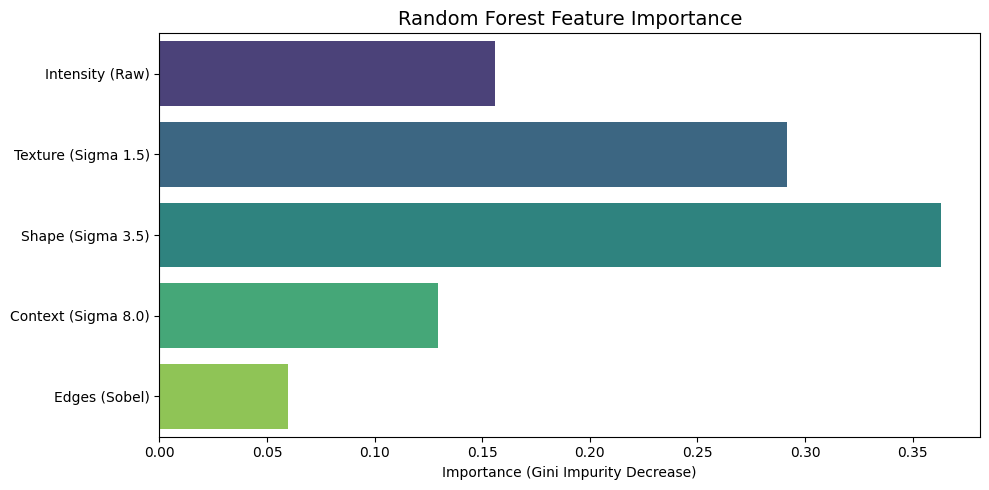

Saved: mask_santi/plot_volume_consistency.png


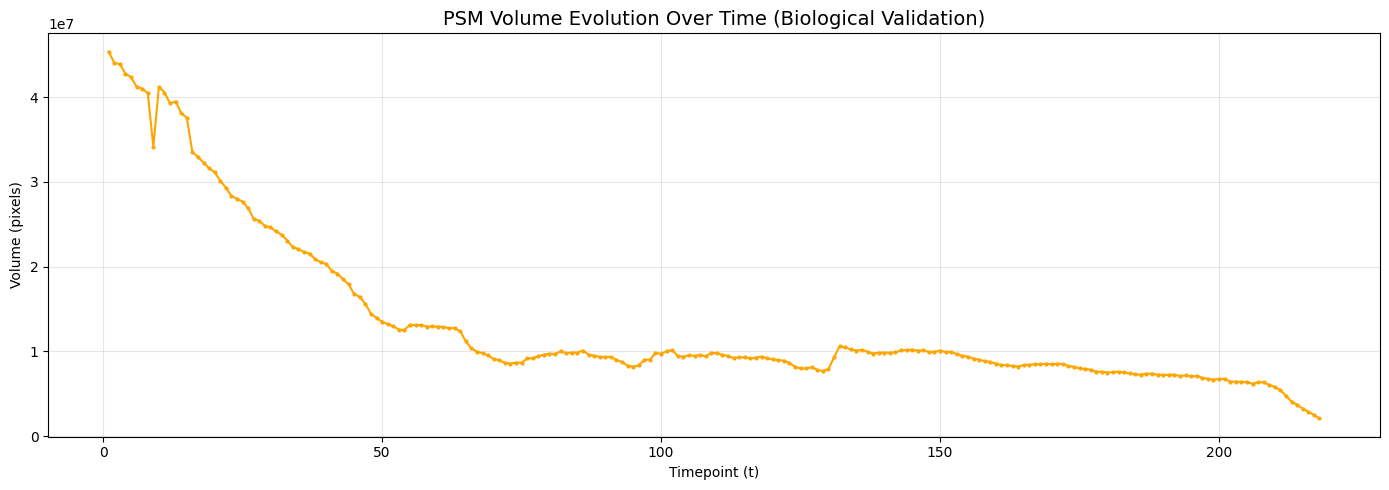


 PROCESSING STATISTICS:
   Total frames processed: 218
   Average time per frame: 129.2 seconds
   Total processing time:  469.4 minutes (7.8 hours)

 BIOLOGICAL VALIDATION:
   Initial PSM volume (t=1):   45,365,797 pixels
   Final PSM volume (t=219):   2,086,396 pixels
   Volume reduction:           95.4%
   → Expected: PSM shrinks as cells differentiate into somites ✓

ALL OUTPUTS SAVED IN: mask_santi
   Masks:     mask_t*.tif (219 files)
   Model:     rf_model_psm.joblib
   Stats:     feature_stats.joblib
   Results:   results.csv
   Plots:     plot_feature_importance.png
                 plot_volume_consistency.png
   Progress:  progress.json


In [ ]:
# =============================================================================
# CELL 7: FINAL REPORT & VISUALIZATION
# =============================================================================
# Generate summary statistics, plots, and save all analytics.
#
# Outputs:
#   - Feature Importance plot (shows which features matter most)
#   - Volume Consistency plot (shows PSM shrinking over time)
#   - Summary statistics (processing time, volume trends)
#
# These visualizations help validate that the segmentation is biologically
# correct: the PSM should shrink monotonically as cells differentiate.
# =============================================================================

# Load results from saved CSV (enables running this cell independently)
if os.path.exists(RESULTS_PATH):
    results_data = pd.read_csv(RESULTS_PATH).to_dict('records')
    print(f" Loaded {len(results_data)} results from {RESULTS_PATH}")

# Load model statistics for feature importance plot
stats_path = os.path.join(OUTPUT_DIR, "feature_stats.joblib")
if os.path.exists(stats_path):
    feature_stats = joblib.load(stats_path)

print("\n" + "="*60)
print("FINAL ANALYTICS REPORT - PSM Segmentation Results")
print("="*60)

if feature_stats:
    names, values = feature_stats
    
    # --- PLOT 1: Feature Importance ---
    # Shows which features the Random Forest relies on most heavily.
    # Expected result: Shape/Texture features > Raw Intensity > Edges
    # This confirms the model learns tissue texture, not just brightness.
    fig1, ax1 = plt.subplots(figsize=(10, 5))
    sns.barplot(x=values, y=names, palette="viridis", ax=ax1)
    ax1.set_title("Random Forest Feature Importance", fontsize=14)
    ax1.set_xlabel("Importance (Gini Impurity Decrease)")
    plt.tight_layout()
    fig1_path = os.path.join(OUTPUT_DIR, "plot_feature_importance.png")
    fig1.savefig(fig1_path, dpi=150, bbox_inches='tight')
    print(f"Saved: {fig1_path}")
    plt.show()

if results_data:
    df = pd.DataFrame(results_data)
    df['Timepoint'] = df['File'].str.extract('(\d+)').astype(int)
    df = df.sort_values('Timepoint')
    
    # --- PLOT 2: Volume Consistency Over Time ---
    # Shows how PSM volume changes across the 219 timepoints.
    # Expected result: Monotonically decreasing curve as PSM shrinks
    # (cells leave PSM to form somites during development).
    fig2, ax2 = plt.subplots(figsize=(14, 5))
    ax2.plot(df['Timepoint'], df['Volume(px)'], marker='.', linestyle='-', color='orange', markersize=4)
    ax2.set_title("PSM Volume Evolution Over Time (Biological Validation)", fontsize=14)
    ax2.set_xlabel("Timepoint (t)")
    ax2.set_ylabel("Volume (pixels)")
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    fig2_path = os.path.join(OUTPUT_DIR, "plot_volume_consistency.png")
    fig2.savefig(fig2_path, dpi=150, bbox_inches='tight')
    print(f"Saved: {fig2_path}")
    plt.show()
    
    # --- SUMMARY STATISTICS ---
    print("\n PROCESSING STATISTICS:")
    print(f"   Total frames processed: {len(df)}")
    print(f"   Average time per frame: {df['Time(s)'].mean():.1f} seconds")
    print(f"   Total processing time:  {df['Time(s)'].sum()/60:.1f} minutes ({df['Time(s)'].sum()/3600:.1f} hours)")
    print(f"\n BIOLOGICAL VALIDATION:")
    print(f"   Initial PSM volume (t=1):   {df['Volume(px)'].iloc[0]:,} pixels")
    print(f"   Final PSM volume (t=219):   {df['Volume(px)'].iloc[-1]:,} pixels")
    print(f"   Volume reduction:           {(1 - df['Volume(px)'].iloc[-1]/df['Volume(px)'].iloc[0])*100:.1f}%")
    print(f"   → Expected: PSM shrinks as cells differentiate into somites ✓")

print("\n" + "="*50)
print("ALL OUTPUTS SAVED IN:", OUTPUT_DIR)
print("="*50)
print("   Masks:     mask_t*.tif (219 files)")
print("   Model:     rf_model_psm.joblib")
print("   Stats:     feature_stats.joblib")
print("   Results:   results.csv")
print("   Plots:     plot_feature_importance.png")
print("                 plot_volume_consistency.png")
print("   Progress:  progress.json")
